<a href="https://colab.research.google.com/github/Coolicc/Big-Data-Analysis-PySpark/blob/main/7th_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Podešavanje Sparka za rad u Google Colabu
#####Izvršite sve komande u datom redosledu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!update-alternatives --config java

There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
!pip install pyspark

     |████████████████████████████████| 217.8MB 62kB/s 
     |████████████████████████████████| 204kB 44.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=61dd4cb5af0340c4b36d2d15592018828fdd3f29c627f75d8e38465de1ea230a
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


####Instaliranje GraphFrame-a
obavezno izvršiti pre kreiranja SparkSession objekta

In [ ]:
!pip install graphframes

     |████████████████████████████████| 163kB 5.1MB/s 


In [ ]:
#obratite pažnju da total nije 0, to znači da se nije ništa skinulo
!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.0-spark2.4-s_2.11.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.0-spark2.4-s_2.11/graphframes-0.8.0-spark2.4-s_2.11.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  371k  100  371k    0     0  1380k      0 --:--:-- --:--:-- --:--:-- 1380k


###Zadatak
Za ovaj zadataka potrebno je da preuzmete fajlove sa adrese https://www.kaggle.com/usdot/flight-delays. Koristeći GraphFrame kreirati graf gde su čvorovi aerodromi (podaci o aerodromu se nalaze u fajlu airports.csv) a grane su letovi koji postoje između dva aerodroma (podaci su u fajlu flights.csv)


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
flights = spark.read.option("header","true").csv("/content/drive/My Drive/flights.csv")
airports = spark.read.option("header","true").csv("/content/drive/My Drive/airports.csv")

In [ ]:
airports = airports.withColumnRenamed("IATA_CODE","id")
flights = flights.withColumnRenamed("ORIGIN_AIRPORT","src").withColumnRenamed("DESTINATION_AIRPORT","dst")

In [ ]:
from graphframes  import GraphFrame
g = GraphFrame(airports, flights)

#### 1. Koliko ima aerodroma?

In [ ]:
g.vertices.count()

322

####2. Koliko ima ukupno letova između svih aerodroma?

In [ ]:
g.edges.count()

5819079

####3. Koji aerodrom ima najviše odlazećih letova? Prikazati grafički 10 najpopularnijih aerodroma.

In [ ]:
g.outDegrees.orderBy("outDegree",ascending=False).show(10)

+---+---------+
| id|outDegree|
+---+---------+
|ATL|   346836|
|ORD|   285884|
|DFW|   239551|
|DEN|   196055|
|LAX|   194673|
|SFO|   148008|
|PHX|   146815|
|IAH|   146622|
|LAS|   133181|
|MSP|   112117|
+---+---------+
only showing top 10 rows



####4. Ako posmtramo aerodrom Chicago O’Hare International Airport (ORD) kao početnu destinaciju, koliko kasne u proseku letovi koji poleću sa njega ka drugim aerodromima. Ispisati 10 aerodroma koje imaju najveće prosečno kašnjenje i koliki je broj letova iz Chicago O’Hare ka tim aerodromima.

In [ ]:
g2 = g.filterEdges("src='ORD'").dropIsolatedVertices()

In [ ]:
import pyspark.sql.functions as F

g2.edges.agg(F.avg(F.col("ARRIVAL_DELAY"))).show()

+------------------+
|avg(ARRIVAL_DELAY)|
+------------------+
| 8.600790442372919|
+------------------+



In [ ]:
from pyspark.sql.types import *

g2.edges.withColumn("ARRIVAL_DELAY",g2.edges["ARRIVAL_DELAY"].cast(IntegerType())).groupBy("dst").avg("ARRIVAL_DELAY").orderBy("avg(ARRIVAL_DELAY)",ascending=False).show(10)

+---+------------------+
|dst|avg(ARRIVAL_DELAY)|
+---+------------------+
|FAI|              37.0|
|COD|              28.5|
|HNL|26.539634146341463|
|STC|23.025974025974026|
|EGE|22.767676767676768|
|ASE| 22.25659050966608|
|ACY|22.224489795918366|
|JAC|21.106770833333332|
|MYR|19.305439330543933|
|COS| 18.60749724366042|
+---+------------------+
only showing top 10 rows



####5. Pronadjite sve letove iz Chicago O’Hare International Airport ka prvom aerodromu po prosečnom kašnjenju (zadatak 4) i vizualizujte te letove tako da na x osi budu datumi leta a na y osi kašnjenje pri polasku

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


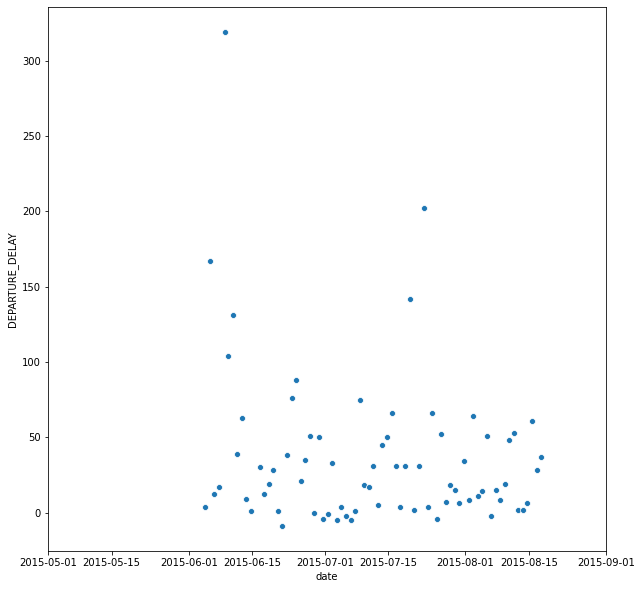

In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

d = g2.filterEdges("src='ORD' AND dst='FAI'").dropIsolatedVertices().edges
d2 = d.withColumn('MONTH', F.when(F.length(F.col('MONTH')) == 1, F.concat(F.lit('0'), F.col('MONTH'))).otherwise(F.col('MONTH'))) \
        .withColumn('DAY', F.when(F.length(F.col('DAY')) == 1, F.concat(F.lit('0'), F.col('DAY'))).otherwise(F.col('DAY'))) \
        .withColumn('date', F.to_timestamp(F.concat(F.col("YEAR"),F.col("MONTH"),F.col("DAY"),F.col("DEPARTURE_TIME")), format='yyyyMMddHHmm'))
p = d2.withColumn("DEPARTURE_DELAY",d2["DEPARTURE_DELAY"].cast(IntegerType())).toPandas()
plt.figure(figsize=(10, 10))
grp = sn.scatterplot(x="date",y="DEPARTURE_DELAY",data=p).set(xlim=(datetime.datetime(2015,5,1),datetime.datetime(2015,9,1)))
plt.show(grp)

####6.Pronaći letove za 15.05.2015 (ili neki drugi datum) kod kojih je tranzitni aerodrom bio San Francisco International Airport (SFO). Tranzitni let znači da je ista avio kompanija sa istim brojem leta letela iz grada A preko San Franciska za grad B i da je vreme poletanja iz San Franciska za grad B veće od vremena stizanja leta iz grada A u San Francisko.

In [ ]:
g3 = g.edges.withColumn("ARRIVAL_TIME",g2.edges["ARRIVAL_TIME"].cast(IntegerType())).withColumn("DEPARTURE_TIME",g2.edges["DEPARTURE_TIME"].cast(IntegerType()))
sf = g.find("(a)-[e]->(s); (s)-[e2]->(b)").filter("s.id='SFO' AND a.id!=b.id AND e.YEAR='2015' AND e.MONTH='5' AND e.DAY='15' AND e2.YEAR='2015' AND e2.MONTH='5' AND e2.DAY='15' AND e.AIRLINE=e2.AIRLINE AND e.FLIGHT_NUMBER=e2.FLIGHT_NUMBER AND e.ARRIVAL_TIME < e2.DEPARTURE_TIME")
sf.select("e","e2").show(20, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|e                                                                                                                                            |e2                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|[2015, 5, 15, 5, OO, 6233, N938SW, ACV, SFO, 1353, 1421, 28, 29, 1450, 71, 92, 55, 250, 1545, 8, 1504, 1553, 49, 0, 0,, 30, 0, 0, 19, 0]     |[2

####7. Koliko minimalno letova treba da promenimo ako želimo da putujemo od San Francisco International Airport do Miami International Airport?

In [ ]:
b = g.bfs("id='SFO'","id='MIA'").columns
int(b[len(b)-2].replace('e',''))

0

####8. Ako izaberemo jedan konkretan aerodrom i jednu konkretnu aviokompaniju, koliko aerodroma možemo posetiti tako da uvek idemo istom aviokompanijom i da se možemo vratiti nazad u izabrani grad. Za svaku avio kompaniju ispisati/vizualizovati koliki je broj tih aerodroma. Za rešenje zadatka koristiti Strongly Connected Components algoritam. Koja avio komapnija ima najveću zajednicu?

In [ ]:
airlines = g.edges.groupBy("AIRLINE").count().select("AIRLINE").collect()
cols = [StructField('Airline',StringType(), True),StructField('Number_of_Components', IntegerType(), True),StructField('Largest_Component', IntegerType(), True)]
schema = StructType(cols)
stats = spark.createDataFrame([], schema)
for ar in airlines:
  al = ar["AIRLINE"]
  sc = g.filterEdges("AIRLINE='"+al+"'").stronglyConnectedComponents(maxIter=10)
  df = spark.createDataFrame([(al, sc.groupBy("component").count().count(), \
                              sc.groupBy("component").count().filter("count>1").orderBy("count", ascending=False).collect()[0]["count"])], schema)
  stats = stats.union(df)
stats.show()

+-------+--------------------+-----------------+
|Airline|Number_of_Components|Largest_Component|
+-------+--------------------+-----------------+
|     UA|                 229|               94|
|     NK|                 289|               34|
|     AA|                 225|               98|
|     EV|                 142|              181|
|     B6|                 259|               64|
|     DL|                 167|              156|
|     OO|                 112|              211|
|     F9|                 260|               63|
|     US|                 244|               79|
|     MQ|                 190|              133|
|     HA|                 306|               17|
|     AS|                 256|               67|
|     VX|                 303|               20|
|     WN|                 237|               86|
+-------+--------------------+-----------------+



+-------+--------------------+-----------------+
|Airline|Number_of_Components|Largest_Component|
+-------+--------------------+-----------------+
|     OO|                 112|              211|
+-------+--------------------+-----------------+
only showing top 1 row

None


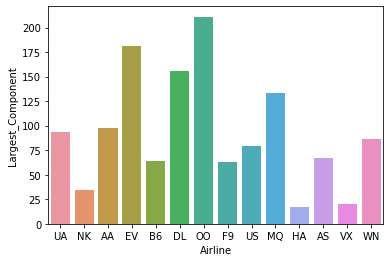

In [ ]:
pstats = stats.toPandas()
print(stats.orderBy("Largest_Component", ascending=False).show(1))
sn.barplot(x="Airline",y="Largest_Component",data=pstats)